In [21]:
import tensorflow as tf

In [22]:
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2 as cv
import imutils
import numpy as np
from matplotlib import pyplot as plt
import time
from os import listdir

%matplotlib inline

In [23]:
def crop_brain_contour(image, plot=False):
  
  gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
  gray = cv.GaussianBlur(gray,(5,5),0)
    
  thresh = cv.threshold(gray,45,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]
  thresh = cv.erode(thresh, None, iterations=2)
  thresh = cv.dilate(thresh,None,iterations=2)

  cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv.contourArea)

  extLeft = tuple(c[c[:,:,0].argmin()][0])
  extRight = tuple(c[c[:,:,0].argmax()][0]) 
  extTop = tuple(c[c[:,:,1].argmin()][0])
  extBot = tuple(c[c[:,:,1].argmax()][0])

  new_image = image[extTop[1]:extBot[1],extLeft[0]:extRight[0]]

  if plot:
    plt.figure()

    plt.subplot(1,2,1)
    plt.imshow(image)

    plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Original image')
    plt.subplot(1,2,2)
    plt.imshow(new_image)

    plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Cropped Image')
    plt.show()

  return new_image

In [24]:
def load_data(dir_list,image_size):
  x=[]
  y=[]

  image_width,image_height = image_size
  for directory in dir_list:
    for filename in listdir(directory):

      #print(directory)
      #print(filename)
      image = cv.imread(directory + '/' + filename)
      #print(image)
      image = crop_brain_contour(image,plot=False)
      image = cv.resize(image,dsize=(image_width,image_height),interpolation = cv.INTER_CUBIC)

      image=image/255
      x.append(image)

      if directory[-3:] == 'yes':
        y.append([1])
      else:
        y.append([0]) 

  X = np.array(x)
  y = np.array(y)

  X,y = shuffle(X,y)

  print(f'Number of examples: {len(X)}')
  print(f'X shape:{X.shape}')
  print(f'Y shape:{y.shape}')

  return X,y

In [25]:
path = 'augmented_dataset/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = path + 'yes' 
augmented_no = path + 'no'

IMG_WIDTH, IMG_HEIGHT = (64, 64)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))


Number of examples: 5678
X shape:(5678, 64, 64, 3)
Y shape:(5678, 1)


In [26]:
def split_data(X, y, test_size=0.2):
  X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
  X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

  return X_train,y_train,X_val,y_val,X_test,y_test

In [27]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [28]:
def build_model(image_shape):
  X_input = Input(image_shape)
  #print(X_input)
    
  X = tf.keras.models.Sequential()
    
  X = Conv2D(filters=32, kernel_size=7, activation='relu')(X_input)

  X = MaxPooling2D(pool_size=4, strides=2)(X)
    
  X = Conv2D(filters=32, kernel_size=7, activation='relu')(X)

  X = MaxPooling2D(pool_size=4, strides=2)(X)

  X = Flatten()(X)

  X = Dense(1,activation='sigmoid')(X)

  model = Model(inputs=X_input,outputs=X,name='TumorDetection')
  return model

In [29]:
IMG_SHAPE = IMG_WIDTH,IMG_HEIGHT,3

In [30]:
model = build_model(IMG_SHAPE)

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [32]:
model.fit(x=X_train,y=y_train,batch_size=32,epochs=15,validation_data=(X_val,y_val))

Train on 3974 samples, validate on 852 samples
Epoch 1/15
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.6204 - acc: 0.6480 - val_loss: 0.6050 - val_acc: 0.6749
Epoch 2/15
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.5202 - acc: 0.7519 - val_loss: 0.5588 - val_acc: 0.7300
Epoch 3/15
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.4798 - acc: 0.7713 - val_loss: 0.4948 - val_acc: 0.7418
Epoch 4/15
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.4461 - acc: 0.7909 - val_loss: 0.4473 - val_acc: 0.7864
Epoch 5/15
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.4085 - acc: 0.8181 - val_loss: 0.4629 - val_acc: 0.7735
Epoch 6/15
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.3640 - acc: 0.8377 - val_loss: 0.4067 - val_acc: 0.8169
Epoch 7/15
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.3428 - acc: 0.8505 - val_loss: 0.4193 - val_acc: 0

In [33]:
model.fit(x=X_train,y=y_train,batch_size=32,epochs=4,validation_data=(X_val,y_val))

Train on 3974 samples, validate on 852 samples
Epoch 1/4
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.1358 - acc: 0.9497 - val_loss: 0.2960 - val_acc: 0.8944
Epoch 2/4
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.1192 - acc: 0.9597 - val_loss: 0.3305 - val_acc: 0.8732
Epoch 3/4
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.1075 - acc: 0.9620 - val_loss: 0.3204 - val_acc: 0.8815
Epoch 4/4
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.0979 - acc: 0.9650 - val_loss: 0.3034 - val_acc: 0.8873


In [34]:
model.fit(x=X_train,y=y_train,batch_size=32,epochs=10,validation_data=(X_val,y_val))

Train on 3974 samples, validate on 852 samples
Epoch 1/10
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.0982 - acc: 0.9693 - val_loss: 0.3565 - val_acc: 0.8862
Epoch 2/10
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.0828 - acc: 0.9748 - val_loss: 0.3209 - val_acc: 0.8850
Epoch 3/10
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.0750 - acc: 0.9756 - val_loss: 0.3234 - val_acc: 0.8920
Epoch 4/10
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.0950 - acc: 0.9648 - val_loss: 0.3233 - val_acc: 0.8944
Epoch 5/10
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.0463 - acc: 0.9892 - val_loss: 0.3204 - val_acc: 0.9061
Epoch 6/10
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.0517 - acc: 0.9879 - val_loss: 0.3663 - val_acc: 0.8932
Epoch 7/10
3974/3974 [==============================] - 31s 8ms/sample - loss: 0.0703 - acc: 0.9753 - val_loss: 0.3463 - val_acc: 0

In [35]:
history = model.history.history


In [36]:
for key in history.keys():
  print(key)

loss
acc
val_loss
val_acc


In [37]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    trainAcc=0
    
    for ele in range(0, len(train_acc)): 
        trainAcc = trainAcc + train_acc[ele]
    
    print('Training Accuracy - ',trainAcc/len(train_acc)*100)
    
    valAcc=0
    
    for ele in range(0, len(val_acc)): 
        valAcc = valAcc + val_acc[ele]
    
    print('Validation Accuracy - ',valAcc/len(val_acc)*100)
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

Training Accuracy -  97.91394054889679
Validation Accuracy -  89.69483554363251


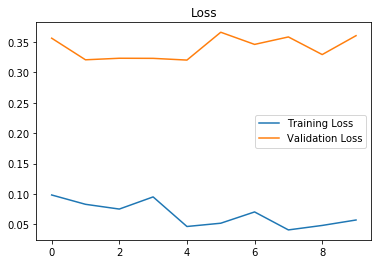

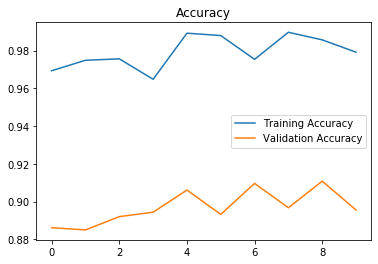

In [38]:
plot_metrics(history)

In [19]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('prediction/yes_or_no_2.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#training_set.class_indices
if result[0][0] == 1:
  prediction = 'tumor detected'
else:
  prediction = 'no tumor detected'

Using TensorFlow backend.


In [20]:
print(prediction)

tumor detected
